## 1 Install Libraries

Installation takes 5 min on A100

In [ ]:
%%capture
!pip uninstall -y numpy pandas jax jaxlib pytensor opencv-python opencv-python-headless opencv-contrib-python tensorflow
!pip install -q torch==2.4.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q transformers==4.44.2 trl==0.9.6 datasets==2.19.0 peft==0.10.0 bitsandbytes==0.43.2 accelerate==0.31.0
!pip install -q numpy==1.26.4 pandas==2.2.2

In [ ]:
!pip install -q sentence-transformers scikit-learn openai

In [ ]:
# Restart
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

In [ ]:
# Version Check
import torch, numpy as np, pandas as pd, transformers, trl, peft, bitsandbytes
print("Torch:", torch.__version__)
print("NumPy:", np.__version__)
print("Transformers:", transformers.__version__)
print("TRL:", trl.__version__)
print("PEFT:", peft.__version__)
print("BitsAndBytes:", bitsandbytes.__version__)

Torch: 2.4.1+cu121
NumPy: 1.26.4
Transformers: 4.44.2
TRL: 0.9.6
PEFT: 0.10.0
BitsAndBytes: 0.43.2


In [ ]:
# libraries
import os, re, gc, json, math, hashlib, random
import numpy as np
import torch
from tqdm import tqdm
from datasets import load_dataset, Dataset
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

from transformers import (
    AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, Trainer, TrainingArguments, DataCollatorWithPadding
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from trl import SFTTrainer
import torch.nn.functional as F

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)

# Clean Memory
gc.collect(); torch.cuda.empty_cache()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
# Clean Memory function
def clear_gpu_memory(verbose=True):
    """Free Python & CUDA memory."""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()
        # optional: reset peak stats for cleaner logging
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()
    if verbose:
        print("Cleared Python GC + CUDA cache.")
clear_gpu_memory()

Cleared Python GC + CUDA cache.


## 2 Data Preprocessing
Herbart Experiments from Psych 101

In [ ]:
from datasets import load_dataset, Dataset
import re

dataset = load_dataset("marcelbinz/Psych-101", split="train")
hebart = dataset.filter(lambda x: "hebart2023things" in x["experiment"])
print("Hebart entries:", len(hebart))

# More robust regex pattern
pattern = r"[A-Z]: [^,]+, [A-Z]: [^,]+,? ?(?:and )?[A-Z]: [^\.]+\.? ?You press <<[A-Z]>>"

def extract_trials(entry):
    matches = re.findall(pattern, entry["text"])
    return [{"text": m.strip()} for m in matches]

trial_list = []
for row in hebart:
    trial_list.extend(extract_trials(row))

hebart_trials = Dataset.from_list(trial_list)
print("Total Hebart trials:", len(hebart_trials))
print("Example:", hebart_trials[0])


Hebart entries: 11122
Total Hebart trials: 2611240
Example: {'text': 'B: prune, J: nail polish, and K: diskette. You press <<K>>'}


### 2.1 Split Train/Val/Test Dataset

In [ ]:
# Full dataset too many
full_split = hebart_trials.train_test_split(test_size=0.20, seed=42)
train_temp = full_split["train"]
test_raw   = full_split["test"]

train_split = train_temp.train_test_split(test_size=0.10, seed=42)
train_raw = train_split["train"]
val_raw   = train_split["test"]

print("Train:", len(train_raw), " Val:", len(val_raw), " Test:", len(test_raw))

# subset: augmentation requires a lot of time and resource even though A100.
train_raw = train_raw.shuffle(seed=42)
val_raw   = val_raw.shuffle(seed=42)
test_raw  = test_raw.shuffle(seed=42)

# Recommended renaming to avoid confusion later
train_raw_small = train_raw.select(range(10000))
val_raw_small   = val_raw.select(range(2000))
test_raw_small  = test_raw.select(range(2000))

print("Train:", len(train_raw_small), " Val:", len(val_raw_small), " Test:", len(test_raw_small))


Train: 1880092  Val: 208900  Test: 522248
Train: 10000  Val: 2000  Test: 2000


### 2.2 Trial Parser

In [ ]:
def parse_trial(text):
    """
    text example:
      "B: prune, J: nail polish, and K: diskette. You press <<K>>"

    returns:
      items:     dict  { "B": "prune", ... }
      keys:      list  ["B","J","K"]
      gold_key:  str   "K"
      gold_item: str   "diskette"
    """
    # extract key-item pairs
    item_pairs = re.findall(r"([A-Z]):\s*([^,]+?)(?:,| and|\.|$)", text)
    items = {k: v.strip() for (k, v) in item_pairs}

    # extract correct key
    m = re.search(r"<<([^>]+)>>", text)
    gold_key = m.group(1).strip()

    # gold item name
    gold_item = items[gold_key]

    keys = list(items.keys())

    return items, keys, gold_key, gold_item


In [ ]:
def keyspace_metrics(dataset, model, tokenizer, device="cuda"):
    """
    Centaur-style 3-way evaluation.
    Input:
        dataset: must contain field ["text"]
    Output:
        mean_nll, accuracy
    """

    model.eval()
    model.to(device)

    nlls = []
    correct = 0
    total = 0

    for ex in tqdm(dataset, desc="Eval 3-way"):
        raw = ex["text"]
        items, keys, gold_key, gold_item = parse_trial(raw)

        # Build Centaur-style prompt
        prefix = raw.split("You press")[0].strip()
        prompt = prefix + "\nYou press"

        # Tokenize
        inputs = tokenizer(prompt, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**inputs).logits[0, -1]

        # Extract logits for only 3 keys
        key_ids = [tokenizer(k, add_special_tokens=False)["input_ids"][0] for k in keys]
        logits_3 = logits[key_ids]
        log_probs = F.log_softmax(logits_3, dim=-1)

        # Compute NLL
        gold_index = keys.index(gold_key)
        nll = -log_probs[gold_index].item()
        nlls.append(nll)

        # Compute accuracy
        pred_index = torch.argmax(logits_3).item()
        pred_key = keys[pred_index]

        if pred_key == gold_key:
            correct += 1

        total += 1

    return {
        "n_examples": total,
        "mean_nll": float(np.mean(nlls)),
        "accuracy": float(correct / total),
    }


## 3 Data Analysis

### 3.1 M1: Centaur like SFT

In [ ]:
# Collect all item names from train/val/test
def collect_item_names(dataset):
    names = []
    splits = []
    for split_name, split_data in dataset.items():
        for ex in split_data:
            items, keys, gold_key, gold_item = parse_trial(ex["text"])
            for k in keys:
                names.append(items[k])
                splits.append(split_name)
    return names, splits

dataset_dict = {
    "train": train_raw_small,
    "val":   val_raw_small,
    "test":  test_raw_small
}

item_names, split_labels = collect_item_names(dataset_dict)
print("Total items:", len(item_names))

# Encode items using SBERT
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer("all-MiniLM-L6-v2")

emb = sbert.encode(item_names, convert_to_tensor=False)
print("Embedding shape:", len(emb), len(emb[0]))

Total items: 42000
Embedding shape: 42000 384


### 3.2 Encoding using SBERT

In [ ]:
# Collect all item names from train/val/test
def collect_item_names(dataset):
    names = []
    splits = []
    for split_name, split_data in dataset.items():
        for ex in split_data:
            items, keys, gold_key, gold_item = parse_trial(ex["text"])
            for k in keys:
                names.append(items[k])
                splits.append(split_name)
    return names, splits

dataset_dict = {
    "train": train_raw_small,
    "val":   val_raw_small,
    "test":  test_raw_small
}

item_names, split_labels = collect_item_names(dataset_dict)
print("Total items:", len(item_names))

# Encode items using SBERT
from sentence_transformers import SentenceTransformer
sbert = SentenceTransformer("all-MiniLM-L6-v2")

emb = sbert.encode(item_names, convert_to_tensor=False)
print("Embedding shape:", len(emb), len(emb[0]))

Total items: 42000
Embedding shape: 42000 384


### 3.3 t-SNE Projection

Total items: 1050


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding shape: 1050 384


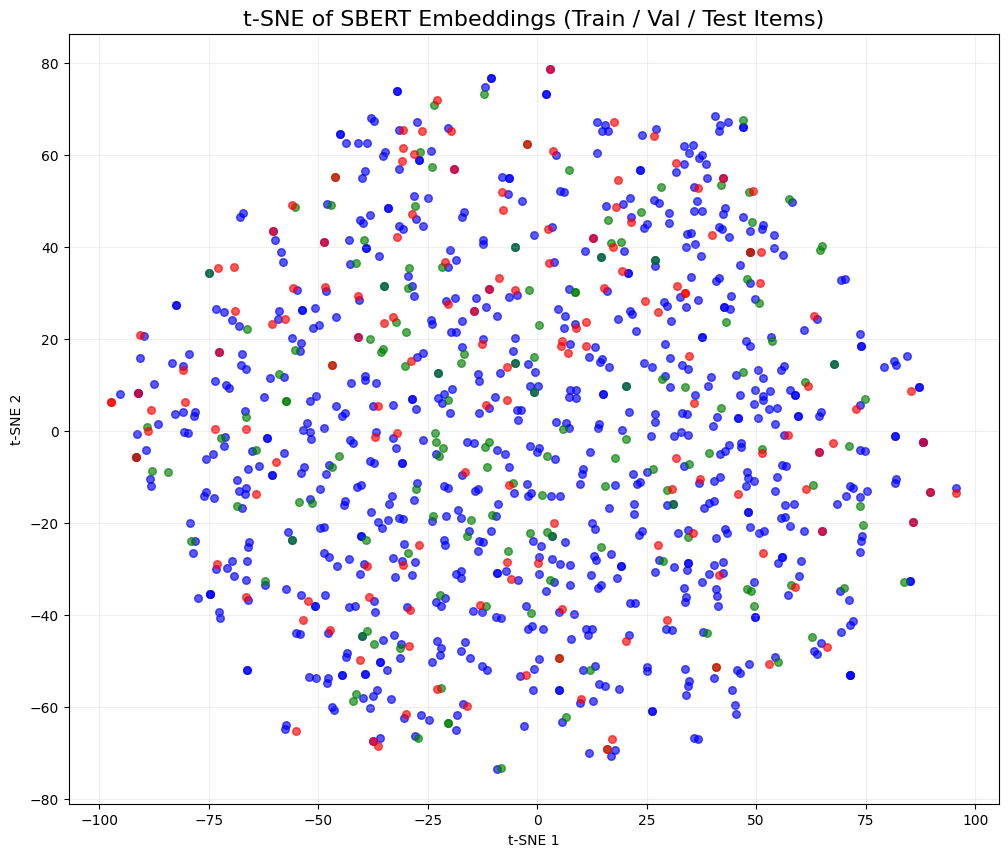

In [ ]:
# t-SNE Projection
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=20, random_state=42)
proj = tsne.fit_transform(emb)

# Plot
colors = {"train": "blue", "val": "green", "test": "red"}

plt.figure(figsize=(12, 10))

for i, label in enumerate(split_labels):
    plt.scatter(
        proj[i, 0], proj[i, 1],
        c=colors[label],
        s=30,
        alpha=0.65
    )

plt.title("t-SNE of SBERT Embeddings (Train / Val / Test Items)", fontsize=16)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(alpha=0.2)
plt.show()


### 3.4 M3 Similarity Accuracy

#### 3.4.1 Calc Accuracy

In [ ]:
def compute_sbert_accuracy(dataset):
    preds = []
    golds = []
    for ex in dataset:
        out = sbert_odd_one_out(ex)
        preds.append(out["pred"])
        golds.append(out["gold"])
    return np.mean([p==g for p,g in zip(preds,golds)])

acc_train = compute_sbert_accuracy(train_raw_small)
acc_val   = compute_sbert_accuracy(val_raw_small)
acc_test  = compute_sbert_accuracy(test_raw_small)

print("Train accuracy:", acc_train)
print("Val accuracy:",   acc_val)
print("Test accuracy:",  acc_test)

Train accuracy: 0.4145
Val accuracy: 0.429
Test accuracy: 0.4185


#### 3.4.2 Similiarity Distance Ditribution

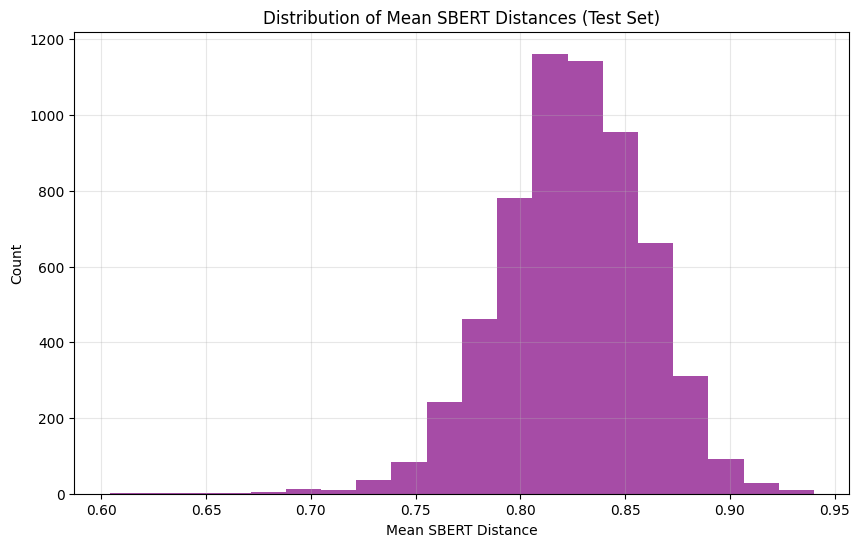

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_mean_distances(ex):
    items, keys, gold_key, gold_item = parse_trial(ex["text"])
    item_list = [items[k] for k in keys]
    vecs = sbert.encode(item_list)

    dmat = np.zeros((3, 3))
    for i in range(3):
        for j in range(3):
            if i != j:
                dmat[i, j] = np.linalg.norm(vecs[i] - vecs[j])

    mean_dist = np.mean(dmat, axis=1)
    pred_index = np.argmax(mean_dist)
    gold_index = keys.index(gold_key)

    return mean_dist, pred_index, gold_index

# Collect distances
all_mean_dists = []
for ex in test_raw_small:
    md, pred, gold = compute_mean_distances(ex)
    all_mean_dists.extend(md)

# Plot
plt.figure(figsize=(10, 6))
plt.hist(all_mean_dists, bins=20, alpha=0.7, color="purple")
plt.title("Distribution of Mean SBERT Distances (Test Set)")
plt.xlabel("Mean SBERT Distance")
plt.ylabel("Count")
plt.grid(alpha=0.3)
plt.show()

#### 3.4.3 Simarity Margin

In [ ]:
import numpy as np

def compute_margins_full(dataset):
    """
    For each trial:
      - compute SBERT mean distances for 3 items
      - margin = max_dist - second_max_dist
      - store (margin, gold, pred)
    """
    margins = []
    golds   = []
    preds   = []

    for ex in dataset:
        out = sbert_odd_one_out(ex)  # gold, pred, dist (list of 3)
        mean_dist = np.array(out["dist"])
        sorted_idx = np.argsort(mean_dist)

        max_idx = sorted_idx[-1]
        second_idx = sorted_idx[-2]
        margin = float(mean_dist[max_idx] - mean_dist[second_idx])

        margins.append(margin)
        golds.append(out["gold"])
        preds.append(out["pred"])

    return np.array(margins), np.array(golds), np.array(preds)

# 1) margin / gold / pred 계산 (예: test set)
margins_test, golds_test, preds_test = compute_margins_full(test_raw_small)

# baseline accuracy
baseline_acc = np.mean(golds_test == preds_test)
print("Baseline SBERT accuracy (test):", baseline_acc)


Baseline SBERT accuracy (test): 0.4185


#### 3.4.4 Top percent accuracy

In [ ]:
def accuracy_top_percent(margins, golds, preds, percent):
    """
    Compute accuracy on the top `percent` of trials
    sorted by SBERT margin (max-dist - second-max-dist).
    """
    assert 0 < percent <= 100
    n = len(margins)
    k = int(n * (percent / 100.0))

    # indices sorted by margin descending
    sorted_idx = np.argsort(margins)[::-1]
    top_idx = sorted_idx[:k]

    top_golds = golds[top_idx]
    top_preds = preds[top_idx]

    acc = np.mean(top_golds == top_preds) if k > 0 else 0.0
    return acc, k

for p in [20, 10, 5, 2, 1]:
    acc_p, k_p = accuracy_top_percent(margins_test, golds_test, preds_test, p)
    print(f"Top {p}% (n={k_p}) accuracy: {acc_p:.3f}")


Top 20% (n=2000) accuracy: 0.514
Top 10% (n=1000) accuracy: 0.582
Top 5% (n=500) accuracy: 0.654
Top 2% (n=200) accuracy: 0.730
Top 1% (n=100) accuracy: 0.740


#### 3.4.5 Accuracy Margin Threshold

In [ ]:
def accuracy_margin_threshold(margins, golds, preds, thresh):
    mask = margins >= thresh
    if mask.sum() == 0:
        return 0.0, 0
    acc = np.mean(golds[mask] == preds[mask])
    return acc, mask.sum()

for t in [0.02, 0.05, 0.08, 0.10]:
    acc_t, n_t = accuracy_margin_threshold(margins_test, golds_test, preds_test, t)
    print(f"Margin >= {t:.2f} (n={n_t}) accuracy: {acc_t:.3f}")


Margin >= 0.02 (n=782) accuracy: 0.510
Margin >= 0.05 (n=134) accuracy: 0.582
Margin >= 0.08 (n=22) accuracy: 0.636
Margin >= 0.10 (n=10) accuracy: 0.600


#### 3.4.6 Confusion Matrix

In [ ]:
def sbert_odd_one_out(example):
    """
    Predict odd-one-out using SBERT semantic distances.

    Returns:
        - gold: the human-chosen key (e.g., "G")
        - pred: the model's predicted key (e.g., "N")
        - dist: mean distance of each item embedding to others
    """
    text = example["text"]

    # Parse the trial into items, keys, and gold label
    items, keys, gold_key, gold_item = parse_trial(text)

    # Convert items into a list of strings (order = keys order)
    item_texts = [items[k] for k in keys]

    # SBERT encoding → shape (3, D)
    emb = sbert.encode(item_texts, convert_to_numpy=True)

    # Compute pairwise distances → shape (3, 3)
    dist_matrix = np.linalg.norm(
        emb[:, None, :] - emb[None, :, :],
        axis=-1
    )

    # Compute mean distance for each item → shape (3,)
    mean_dist = dist_matrix.mean(axis=1)

    # Prediction = item that is farthest from the other two
    pred_index = int(np.argmax(mean_dist))
    pred_key = keys[pred_index]

    return {
        "gold": gold_key,           # e.g. "N"
        "pred": pred_key,           # SBERT predicted key
        "dist": mean_dist.tolist()  # 3 numbers
    }


In [ ]:
def confusion_matrix_sbert(dataset):
    cm = np.zeros((3,3))

    for ex in dataset:
        out = sbert_odd_one_out(ex)
        items, keys, gold_key, gold_item = parse_trial(ex["text"])

        # normalize keys → indices 0,1,2
        gold_index = keys.index(gold_key)
        pred_index = keys.index(out["pred"])

        cm[gold_index][pred_index] += 1

    cm = cm / cm.sum()
    return cm


#### 3.4.7 Confusio Martix Visualization

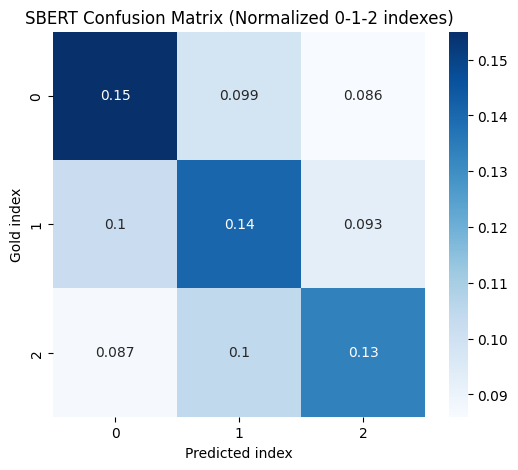

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm_val = confusion_matrix_sbert(val_raw_small)

plt.figure(figsize=(6,5))
sns.heatmap(cm_val, annot=True, cmap="Blues",
            xticklabels=[0,1,2],
            yticklabels=[0,1,2])
plt.xlabel("Predicted index")
plt.ylabel("Gold index")
plt.title("SBERT Confusion Matrix (Normalized 0-1-2 indexes)")
plt.show()


### 4 Result Check

In [ ]:
results_test = test_raw_small.map(sbert_odd_one_out)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
wrong_examples = []
for ex, out in zip(test_raw_small, results_test):
    if out["gold"] != out["pred"]:
        wrong_examples.append((ex["text"], out))


In [ ]:
print("Number of wrong predictions:", len(wrong_examples))

Number of wrong predictions: 1163


In [ ]:
def show_wrong_case(idx):
    text, out = wrong_examples[idx]

    items, keys, gold_key, gold_item = parse_trial(text)
    mean_dist = out["dist"]

    print(f"\n=== Wrong Case {idx} ===")
    print(text)
    print("\nItems:")
    for i, k in enumerate(keys):
        print(f"  {k}: {items[k]} (mean_dist={mean_dist[i]:.4f})")

    print(f"\nGold key: {gold_key} → item: {items[gold_key]}")
    print(f"Pred key: {out['pred']} → item: {items[out['pred']]}")

# Show first 3 wrong examples
for i in range(min(3, len(wrong_examples))):
    show_wrong_case(i)



=== Wrong Case 0 ===
D: shower curtain, G: nail, and N: rope. You press <<G>>

Items:
  D: shower curtain (mean_dist=0.8183)
  G: nail (mean_dist=0.7441)
  N: rope (mean_dist=0.7492)

Gold key: G → item: nail
Pred key: D → item: shower curtain

=== Wrong Case 1 ===
W: snowboard, P: float, and V: trap. You press <<V>>

Items:
  W: snowboard (mean_dist=0.8002)
  P: float (mean_dist=0.7694)
  V: trap (mean_dist=0.7967)

Gold key: V → item: trap
Pred key: W → item: snowboard

=== Wrong Case 2 ===
U: glove, Z: minivan, and L: polo shirt. You press <<U>>

Items:
  U: glove (mean_dist=0.8008)
  Z: minivan (mean_dist=0.8516)
  L: polo shirt (mean_dist=0.8007)

Gold key: U → item: glove
Pred key: Z → item: minivan
